In [116]:
# load lib
import ROOT
import os, sys
import numpy as np
import pandas as pd
import nlfir
from matplotlib import pyplot as plt
import numba as nb

In [137]:
# load style
from ROOT import gROOT

path = '/Users/yy/cernbox/'
# path = '/eos/user/y/youyou/'
gROOT.SetMacroPath(path+"atlasstyle/")
gROOT.LoadMacro("AtlasLabels.C")
gROOT.LoadMacro("AtlasStyle.C")
gROOT.LoadMacro("AtlasUtils.C")
from ROOT import SetAtlasStyle, ATLASLabel, myText, myMarkerText
SetAtlasStyle()


Applying ATLAS style settings...



### functions

In [179]:

def data_reader(data_folder, data_folder_of):
    pulse = np.loadtxt(data_folder+'/ideal_output_sequence.txt')
    adc = np.loadtxt(data_folder+'/digits_out_sequence_eT.txt')
    signal = np.loadtxt(data_folder+'/hit_eT_sig_sequence.txt')
    pileup = np.loadtxt(data_folder+'/hit_eT_bck_sequence.txt')
    
    of_out = np.loadtxt(data_folder_of+'/digits_out_sequence_eT.txt')
    of_coeff = np.loadtxt(data_folder_of+'/configuration.txt')

    return pulse, adc, signal, pileup, of_coeff, of_out

In [200]:
def error_bar(pred, adc, h):
    difference = pred - adc
    # noise_variance = np.mean(difference**2)
    # denominator = np.dot(h, np.conj(h))

    return np.sqrt(np.std(difference) / sum(h**2))

In [263]:
def optimal(of_out, of_coeff, to_cut=int(1e6)):
    of_out = of_out[5+to_cut: 5-to_cut]

    return of_out, of_coeff

In [94]:
def all_les_mat(adc, signal, pileup, jl=30, jr=8, ncut=10000, thresh=1.5, adjusted=0):
    npad=len(adc)-len(pileup)

    signal=np.hstack([signal,np.zeros(npad)])
    pileup=np.hstack([pileup,np.zeros(npad)])

    nn=jl+jr+2
    mat=np.zeros([len(adc),nn])  
    mm=np.zeros([len(adc)-2*ncut,nn])
    for i in range(nn-1):
        mm[:,i]=adc[ncut-jl+i:-ncut-jl+i]
    mm[:,-1]=1
    mm_quad=np.hstack([mm,mm[:,:-1]**2])
    mm_cub=np.hstack([mm,mm[:,:-1]**2,mm[:,:-1]**3])

    def _matrix_mult(mm):
        ss=(signal+pileup)[ncut:-ncut]

        lhs=mm.T@mm
        rhs=mm.T@ss
        coeffs=np.linalg.inv(lhs)@rhs
        pred=mm@coeffs
    
        return pred, coeffs

    if adjusted:
        error = ss - pred1
        mask = np.abs(error) > thresh
        poly_coeffs = np.polyfit(pred1[mask], error[mask], deg=1)
        pred1[mask] = np.polyval(poly_coeffs, pred1[mask])

    return _matrix_mult(mm), _matrix_mult(mm_quad), _matrix_mult(mm_cub)

In [182]:
def lin_les_fft(adc, signal, pileup, jl=30, jr=8, to_cut=int(1e6), thresh=1.5):
    s=signal+pileup
    k1=to_cut  #k1/k2 define the stretch of data we'll use
    k2=-k1

    ones=0.0*adc+1.0
    mat=nlfir.FIRmat(ones,0,0,k1,k2) #initialize the matrix with the constant offset term
    mat.add_vec(adc,jl,jr)  #include the linear part of the response to the ADCs
    mat.get_fts() #do this once you've added everything you want
    mat.get_coeffs(s)
    pred=mat.get_pred()

    mat.set_adjust(s,thresh)
    pred_adjust=mat.get_pred(adjust=True)[to_cut: -to_cut]

    h = np.fft.rfft(mat.coeffs)

    return pred_adjust, h

In [183]:
def quad_les_fft(adc, signal, pileup, jl=30, jr=8, to_cut=int(1e6), thresh=1.5):
    s=signal+pileup
    k1=to_cut  #k1/k2 define the stretch of data we'll use
    k2=-k1

    ones=0.0*adc+1.0

    nlmat=nlfir.FIRmat(ones,0,0,k1,k2) #initialize the matrix with the constant offset term
    nlmat.add_vec(adc,jl,jr)  #include the linear part of the response to the ADCs
    nlmat.add_vec(adc**2,jl,jr)  #we can add the nonlinear part now
    nlmat.get_fts() #do this once you've added everything you want
    nlmat.get_coeffs(s)
    nlpred=nlmat.get_pred()

    nlmat.set_adjust(s,thresh)
    nlpred_adjust=nlmat.get_pred(adjust=True)[to_cut: -to_cut]

    h = np.fft.rfft(nlmat.coeffs)

    return nlpred_adjust, h

In [184]:
def cub_les_fft(adc, signal, pileup, jl=30, jr=8, to_cut=int(1e6), thresh=1.5):
    s=signal+pileup
    k1=to_cut  #k1/k2 define the stretch of data we'll use
    k2=-k1

    ones=0.0*adc+1.0

    nlmat=nlfir.FIRmat(ones,0,0,k1,k2) #initialize the matrix with the constant offset term
    nlmat.add_vec(adc,jl,jr)  #include the linear part of the response to the ADCs
    nlmat.add_vec(adc**2,jl,jr)  #we can add the nonlinear part now
    nlmat.add_vec(adc**3,jl,jr) 
    nlmat.get_fts() #do this once you've added everything you want
    nlmat.get_coeffs(s)
    nlpred=nlmat.get_pred()

    nlmat.set_adjust(s,thresh)
    nlpred_adjust=nlmat.get_pred(adjust=True)[to_cut: -to_cut]

    h = np.fft.rfft(nlmat.coeffs)

    return nlpred_adjust, h

In [118]:
@nb.njit(parallel=True)
def indices_gen(e_true):
    bins = np.linspace(np.min(e_true), np.max(e_true), 11)
    bin_indices = np.digitize(e_true, bins)
    indices, x = [], []
    
    for j in range(1, len(bins)):
        x.append((bins[j-1] + bins[j]) / 2)
        indices.append(np.where(bin_indices == j)[0])

    return indices, x


In [128]:
@nb.njit(parallel=True)
def arr_generator(e_diff, true_signal, indices):
    n_indices = len(indices)
    
    # Pre-allocate numpy arrays for the output to avoid using Python lists
    mean = np.empty(n_indices)
    std = np.empty(n_indices)
    median = np.empty(n_indices)
    lower_98 = np.empty(n_indices)
    higher_98 = np.empty(n_indices)
    scale_mean = np.empty(n_indices)
    scale_std = np.empty(n_indices)

    # Calculate the scales array once
    scales = e_diff / true_signal
    
    for i in nb.prange(n_indices):
        i_arr = indices[i]
        # Use np array indexing instead of list comprehension
        data = e_diff[i_arr]

        mean[i] = data.mean()
        std[i] = data.std()
        
        # Use the pre-computed scales array
        scale_data = scales[i_arr]
        scale_mean[i] = scale_data.mean()
        scale_std[i] = scale_data.std()
        
        # Use the built-in np.percentile function to calculate quantiles directly
        lower, upper = np.percentile(data, [1, 99])
        # Use np's boolean indexing to filter the signal
        filtered_signal = data[(data >= lower) & (data <= upper)]
        
        median[i] = np.median(filtered_signal)
        lower_98[i] = lower
        higher_98[i] = upper
    
    return mean, std, median, lower_98, higher_98, scale_mean, scale_std


In [218]:
def mean_hist_gen(x, mean_of, std_of, mean_lin, std_lin, mean_quad, std_quad, mean_cub, std_cub, y_min, y_max):
    shift_x = x[-1]/100

    graph1 = ROOT.TGraphErrors(len(x), np.array(x, 'd')+shift_x, np.array(mean_of, 'd'), np.zeros(len(x)), np.array(std_of, 'd'))
    graph1.SetMarkerStyle(22)
    graph1.SetMarkerSize(1.5)
    graph1.SetLineColorAlpha(ROOT.kRed, 0.8)
    graph1.SetLineWidth(2)
    graph1.SetMarkerColorAlpha(ROOT.kRed, 0.8)

    graph2 = ROOT.TGraphErrors(len(x), np.array(x, 'd'), np.array(mean_quad, 'd'), np.zeros(len(x)), np.array(std_quad, 'd'))
    graph2.SetMarkerStyle(20)
    graph2.SetMarkerSize(1.5)
    graph2.SetLineColorAlpha(ROOT.kBlue, 0.8)
    graph2.SetMarkerColorAlpha(ROOT.kBlue, 0.8)
    graph2.SetLineWidth(2)

    graph3 = ROOT.TGraphErrors(len(x), np.array(x, 'd')-shift_x, np.array(mean_lin, 'd'), np.zeros(len(x)), np.array(std_lin, 'd'))
    graph3.SetMarkerStyle(23)
    graph3.SetMarkerSize(1.5)
    graph3.SetLineColorAlpha(ROOT.kOrange+1, 0.9)
    graph3.SetMarkerColorAlpha(ROOT.kOrange+1, 0.9)
    graph3.SetLineWidth(2)

    graph4 = ROOT.TGraphErrors(len(x), np.array(x, 'd')+2*shift_x, np.array(mean_cub, 'd'), np.zeros(len(x)), np.array(std_cub, 'd'))
    graph4.SetMarkerStyle(21)
    graph4.SetMarkerSize(1.4)
    graph4.SetLineColorAlpha(ROOT.kSpring-8, 0.9)
    graph4.SetMarkerColorAlpha(ROOT.kSpring-8, 0.9)
    graph4.SetLineWidth(2)

    graph1.GetXaxis().SetTitle("E_{true} = (E_{sig}+E_{PU}) [GeV]")
    graph1.GetYaxis().SetTitle("mean of \DeltaE [GeV]")
    graph1.GetYaxis().SetRangeUser(y_min, y_max)

    legend = ROOT.TLegend(0.6, 0.75, 0.95, 0.95)
    legend.AddEntry(graph1, "E_{reco} with OF", "lep")
    legend.AddEntry(graph3, "E_{reco} with Linear Filter", "lep")
    legend.AddEntry(graph2, "E_{reco} with Quadratic Filter", "lep")
    legend.AddEntry(graph4, "E_{reco} with Cubic Filter", "lep")

    return graph1, graph2, graph3, graph4, legend

In [219]:
def std_hist_gen(x, indices, std_of, std_lin, std_quad, std_cub, y_min, y_max):
    shift_x = x[-1]/100

    n = np.array([len(i) for  i in indices])

    y = np.array(std_of)
    uncertainty_y = y / np.sqrt(2 * n-2)
    y[0] = 0.65
    y[1] = 0.65
    graph1 = ROOT.TGraphErrors(len(x), np.array(x, 'd')-shift_x, np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))
    graph1.SetMarkerStyle(22)
    graph1.SetMarkerSize(1.5)
    graph1.SetLineColorAlpha(ROOT.kRed, 0.8)
    graph1.SetLineWidth(2)
    graph1.SetMarkerColorAlpha(ROOT.kRed, 0.8)

    y = np.array(std_quad)
    uncertainty_y = y / np.sqrt(2 * n-2)

    graph2 = ROOT.TGraphErrors(len(x), np.array(x, 'd')+shift_x, np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))
    graph2.SetMarkerStyle(20)
    graph2.SetMarkerSize(1.5)
    graph2.SetLineColorAlpha(ROOT.kBlue, 0.8)
    graph2.SetMarkerColorAlpha(ROOT.kBlue, 0.8)
    graph2.SetLineWidth(2)

    y = np.array(std_lin)
    uncertainty_y = y / np.sqrt(2 * n-2)
    y[0] = 0.65
    graph3 = ROOT.TGraphErrors(len(x), np.array(x, 'd'), np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))
    graph3.SetMarkerStyle(20)
    graph3.SetMarkerSize(1.5)
    graph3.SetLineColorAlpha(ROOT.kOrange+1, 0.9)
    graph3.SetMarkerColorAlpha(ROOT.kOrange+1, 0.9)
    graph3.SetLineWidth(2)

    y = np.array(std_cub)
    uncertainty_y = y / np.sqrt(2 * n-2)

    graph4 = ROOT.TGraphErrors(len(x), np.array(x, 'd')+2*shift_x, np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))
    graph4.SetMarkerStyle(21)
    graph4.SetMarkerSize(1.4)
    graph4.SetLineColorAlpha(ROOT.kSpring-8, 0.9)
    graph4.SetMarkerColorAlpha(ROOT.kSpring-8, 0.9)
    graph4.SetLineWidth(2)


    graph1.GetXaxis().SetTitle("E_{true} = (E_{sig}+E_{PU}) [GeV]")
    graph1.GetYaxis().SetTitle("\sigma_{\DeltaE}  [GeV]")
    graph1.GetYaxis().SetRangeUser(y_min, y_max)

    legend = ROOT.TLegend(0.6, 0.75, 0.95, 0.95)
    legend.AddEntry(graph1, "E_{reco} with OF", "lep")
    legend.AddEntry(graph3, "E_{reco} with Linear Filter", "lep")
    legend.AddEntry(graph2, "E_{reco} with Quadratic Filter", "lep")
    legend.AddEntry(graph4, "E_{reco} with Cubic Filter", "lep")

    return graph1, graph2, graph3, graph4, legend

In [220]:
def median_hist_gen(x, median_of, lower_98_of, higher_98_of, median_quad, lower_98_quad, higher_98_quad, median_lin, lower_98_lin, higher_98_lin, median_cub, lower_98_cub, higher_98_cub, y_min, y_max):

    shift_x = x[-1]/100

    y = np.array(median_of, 'd')
    lower_error = np.array(lower_98_of, 'd')  
    upper_error = np.array(higher_98_of, 'd')  

    graph1 = ROOT.TGraphAsymmErrors(len(x), np.array(x, 'd')-shift_x, y, np.zeros(len(x)), np.zeros(len(x)), y-lower_error, upper_error-y)
    graph1.SetMarkerStyle(22)
    graph1.SetMarkerSize(1.5)
    graph1.SetLineColorAlpha(ROOT.kRed, 0.8)
    graph1.SetLineWidth(2)
    graph1.SetMarkerColorAlpha(ROOT.kRed, 0.8)

    y = np.array(median_quad, 'd')
    lower_error = np.array(lower_98_quad, 'd')  
    upper_error = np.array(higher_98_quad, 'd')  

    graph2 = ROOT.TGraphAsymmErrors(len(x), np.array(x, 'd')+shift_x, y, np.zeros(len(x)), np.zeros(len(x)), y-lower_error, upper_error-y)
    graph2.SetMarkerStyle(20)
    graph2.SetMarkerSize(1.5)
    graph2.SetLineColorAlpha(ROOT.kOrange+1, 0.9)
    graph2.SetMarkerColorAlpha(ROOT.kOrange+1, 0.9)
    graph2.SetLineWidth(2)


    y = np.array(median_lin, 'd')
    lower_error = np.array(lower_98_lin, 'd')  
    upper_error = np.array(higher_98_lin, 'd')  
    graph3 = ROOT.TGraphAsymmErrors(len(x), np.array(x, 'd'), y, np.zeros(len(x)), np.zeros(len(x)), y-lower_error, upper_error-y)
    graph3.SetMarkerStyle(20)
    graph3.SetMarkerSize(1.5)
    graph3.SetLineColorAlpha(ROOT.kBlue, 0.8)
    graph3.SetMarkerColorAlpha(ROOT.kBlue, 0.8)
    graph3.SetLineWidth(2)


    y = np.array(median_cub, 'd')
    lower_error = np.array(lower_98_cub, 'd')  
    upper_error = np.array(higher_98_cub, 'd')  
    graph4 = ROOT.TGraphAsymmErrors(len(x), np.array(x, 'd')+2*shift_x, y, np.zeros(len(x)), np.zeros(len(x)), y-lower_error, upper_error-y)
    graph4.SetMarkerStyle(21)
    graph4.SetMarkerSize(1.4)
    graph4.SetLineColorAlpha(ROOT.kSpring-8, 0.9)
    graph4.SetMarkerColorAlpha(ROOT.kSpring-8, 0.9)
    graph4.SetLineWidth(2)


    graph1.GetXaxis().SetTitle("E_{true} = (E_{sig}+E_{PU}) [GeV]")
    graph1.GetYaxis().SetTitle("(\Delta E)_{1/2} with 98% [GeV]")
    graph1.GetYaxis().SetRangeUser(y_min, y_max)

    legend = ROOT.TLegend(0.6, 0.75, 0.95, 0.95)
    legend.AddEntry(graph1, "E_{reco} with OF", "lep")
    legend.AddEntry(graph3, "E_{reco} with Linear Filter", "lep")
    legend.AddEntry(graph2, "E_{reco} with Quadratic Filter", "lep")
    legend.AddEntry(graph4, "E_{reco} with Cubic Filter", "lep")


    return graph1, graph2, graph3, graph4, legend

In [221]:
def rela_std_hist_gen(x, indices, scale_std_of, scale_std_lin, scale_std_quad, scale_std_cub, y_min, y_max):

    shift_x = x[-1]/100

    n = np.array([len(i) for  i in indices])

    y = np.array(scale_std_of)
    uncertainty_y = y / np.sqrt(2 * n-2)
    y[0] = y_max
    y[1] = y_max
    graph1 = ROOT.TGraphErrors(len(x), np.array(x, 'd')-shift_x, np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))
    graph1.SetMarkerStyle(22)
    graph1.SetMarkerSize(1.5)
    graph1.SetLineColorAlpha(ROOT.kRed, 0.8)
    graph1.SetLineWidth(2)
    graph1.SetMarkerColorAlpha(ROOT.kRed, 0.8)

    y = np.array(scale_std_quad)
    y[0] = y_max
    uncertainty_y = y / np.sqrt(2 * n-2)
    graph2 = ROOT.TGraphErrors(len(x), np.array(x, 'd')+shift_x, np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))
    graph2.SetMarkerStyle(20)
    graph2.SetMarkerSize(1.5)
    graph2.SetLineColorAlpha(ROOT.kBlue, 0.8)
    graph2.SetMarkerColorAlpha(ROOT.kBlue, 0.8)
    graph2.SetLineWidth(2)

    y = np.array(scale_std_lin)
    y[0] = y_max
    y[1] = y_max
    uncertainty_y = y / np.sqrt(2 * n-2)
    graph3 = ROOT.TGraphErrors(len(x), np.array(x, 'd'), np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))
    graph3.SetMarkerStyle(20)
    graph3.SetMarkerSize(1.5)
    graph3.SetLineColorAlpha(ROOT.kOrange+1, 0.9)
    graph3.SetMarkerColorAlpha(ROOT.kOrange+1, 0.9)
    graph3.SetLineWidth(2)

    y = np.array(scale_std_cub)
    y[0] = y_max
    uncertainty_y = y / np.sqrt(2 * n-2)
    graph4 = ROOT.TGraphErrors(len(x), np.array(x, 'd')-2*shift_x, np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))
    graph4.SetMarkerStyle(21)
    graph4.SetMarkerSize(1.4)
    graph4.SetLineColorAlpha(ROOT.kSpring-8, 0.9)
    graph4.SetMarkerColorAlpha(ROOT.kSpring-8, 0.9)
    graph4.SetLineWidth(2)

    graph1.GetXaxis().SetTitle("E_{true}=(E_{sig}+E_{PU})  [GeV]")
    graph1.GetYaxis().SetTitle("\sigma_{(\Delta E/E_{true})}  [GeV]")
    graph1.GetYaxis().SetRangeUser(y_min, y_max)
    #graph1.GetYaxis().SetRangeUser(0., 1)

    legend = ROOT.TLegend(0.6, 0.75, 0.95, 0.95)
    legend.AddEntry(graph1, "E_{reco} with OF", "lep")
    legend.AddEntry(graph3, "E_{reco} with Linear Filter", "lep")
    legend.AddEntry(graph2, "E_{reco} with Quadratic Filter", "lep")
    legend.AddEntry(graph4, "E_{reco} with Cubic Filter", "lep")

    return graph1, graph2, graph3, graph4, legend

### first HEC

In [387]:
# load data

data_folder = './data/'
pulse = np.loadtxt(data_folder + 'pule_shape.txt')  # pulse shape
adc = np.loadtxt(data_folder + 'adc_out.txt')       # simulated adc output
signal = np.loadtxt(data_folder + 'signal.txt')     # delta func signal
pileup = np.loadtxt(data_folder + 'pileup.txt')     # pileup noise

of_coeff = np.loadtxt(data_folder + 'of_coeffs.txt')# optimal filter coefficients 
of_out = np.loadtxt(data_folder + 'of_out.txt')     # optimal filter output with above coeffs


In [396]:
ss=(signal+pileup)

to_cut=10000
ss = ss[to_cut: 5-to_cut]

of_pred, of_h = optimal(of_out, of_coeff, to_cut=to_cut)

(lin_pred, lin_h), (quad_pred, quad_h), (cub_pred, cub_h) = all_les_mat(adc, signal, pileup, ncut=to_cut)

In [397]:
print('error for all BCID:  ')
print('optimal filter:  ', np.std(of_pred-ss))
print('linear FIR filter:  ', np.std(lin_pred-ss))
print('quadratic FIR filter:  ', np.std(quad_pred-ss))
print('cubic FIR filter:  ', np.std(cub_pred-ss))
print()

print('error for only 1 signal(ideal error):  ')
print('optimal filter:  ', error_bar(of_pred, adc[to_cut: -to_cut], of_h))
print('linear FIR filter:  ', error_bar(lin_pred, adc[to_cut: -to_cut], lin_h))
print('quadratic FIR filter:  ', error_bar(quad_pred, adc[to_cut: -to_cut], quad_h))
print('cubic FIR filter:  ', error_bar(cub_pred, adc[to_cut: -to_cut], cub_h))


error for all BCID:  
optimal filter:   3.2879159420938806
linear FIR filter:   0.7164750246992453
quadratic FIR filter:   0.3953894855056812
cubic FIR filter:   0.33015096710609354

error for only 1 signal(ideal error):  
optimal filter:   1.5744445231104913
linear FIR filter:   0.5800325540961151
quadratic FIR filter:   0.7777019807570871
cubic FIR filter:   0.9215795296031735


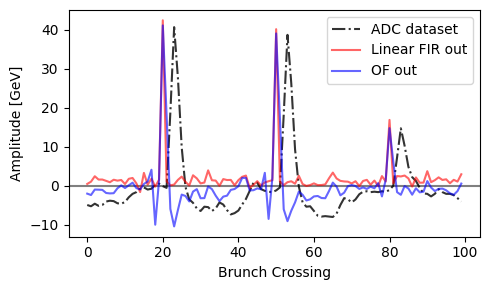

In [390]:

plt.figure(figsize=(5,3))

plt.axhline(0, color='gray', linestyle='-') 

plt.plot(adc[100200+to_cut:100300+to_cut], 'k-.', alpha=0.8, label='ADC dataset')
plt.plot(lin_pred[100200:100300], 'r', alpha=0.6, label='Linear FIR out')
plt.plot(of_pred[100200:100300], 'b', alpha=0.6, label='OF out')


plt.xlabel('Brunch Crossing')
plt.ylabel('Amplitude [GeV]')

plt.legend()
plt.tight_layout()
plt.savefig('hec_data.pdf')
plt.show()

In [398]:
indices, x = indices_gen(ss)


e_diff_of = (of_pred) - (ss)

mean_of, std_of, median_of, lower_98_of, higher_98_of, scale_mean_of, scale_std_of = arr_generator(e_diff_of, ss, indices)


e_diff_lin = (lin_pred) - (ss)

mean_lin, std_lin, median_lin, lower_98_lin, higher_98_lin, scale_mean_lin, scale_std_lin = arr_generator(e_diff_lin, ss, indices)


e_diff_quad = (quad_pred) - (ss)

mean_quad, std_quad, median_quad, lower_98_quad, higher_98_quad, scale_mean_quad, scale_std_quad = arr_generator(e_diff_quad, ss, indices)


e_diff_cub = (cub_pred) - (ss)

mean_cub, std_cub, median_cub, lower_98_cub, higher_98_cub, scale_mean_cub, scale_std_cub = arr_generator(e_diff_cub, ss, indices)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file mean_hec.pdf has been created


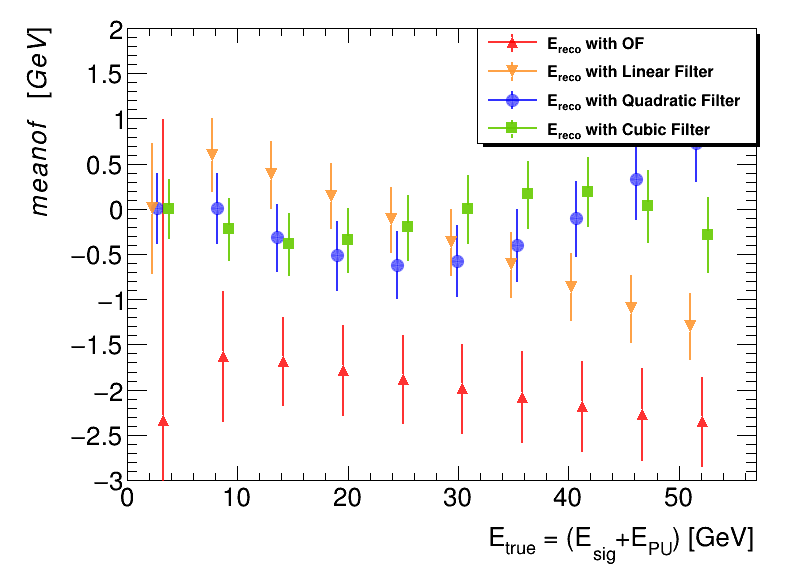

In [399]:
graph1, graph2, graph3, graph4, legend = mean_hist_gen(x, mean_of, std_of, mean_lin, std_lin, mean_quad, std_quad, mean_cub, std_cub, -3, 2)

canvas = ROOT.TCanvas("canvas", "Comparison Canvas", 800, 600)

graph1.Draw("APE")
graph2.Draw("SAMEPE")
graph3.Draw("SAMEPE")
graph4.Draw("SAMEPE")
legend.Draw()

canvas.Update()
canvas.Draw()
canvas.Print('mean_hec.pdf')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file std_hec.pdf has been created


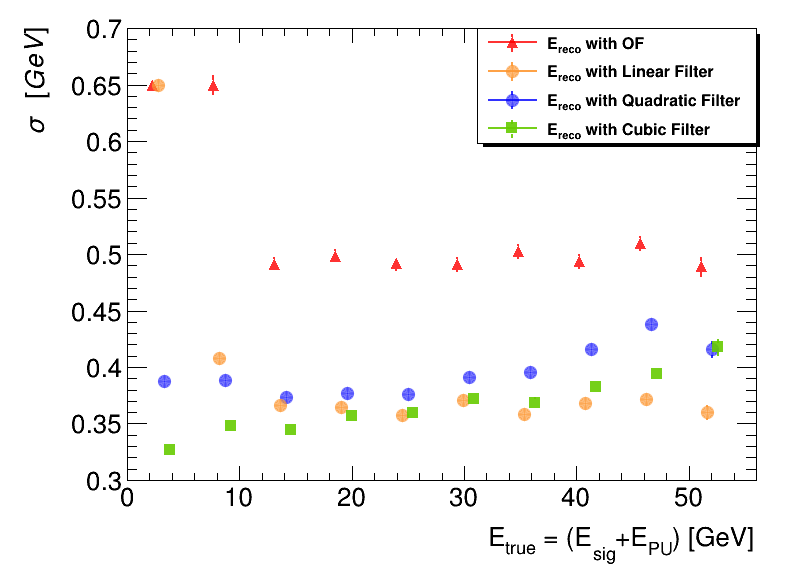

In [400]:
graph1, graph2, graph3, graph4, legend = std_hist_gen(x, indices, std_of, std_lin, std_quad, std_cub, .3, .7)

canvas = ROOT.TCanvas("canvas", "Comparison Canvas", 800, 600)

graph1.Draw("APE")
graph2.Draw("SAMEPE")
graph3.Draw("SAMEPE")
graph4.Draw("SAMEPE")
legend.Draw()

canvas.Update()
canvas.Draw()
canvas.Print('std_hec.pdf')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file median_hec.pdf has been created


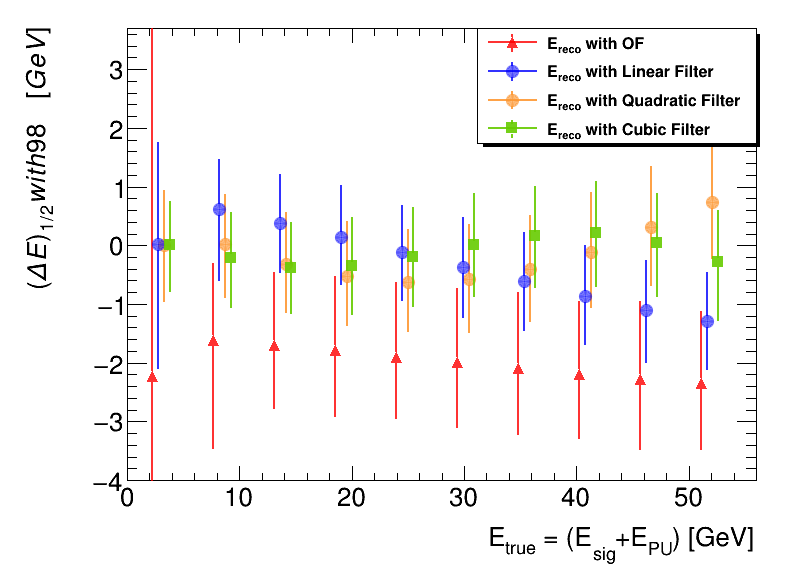

In [401]:
graph1, graph2, graph3, graph4, legend = median_hist_gen(x, median_of, lower_98_of, higher_98_of, median_quad, lower_98_quad, higher_98_quad, median_lin, lower_98_lin, higher_98_lin, median_cub, lower_98_cub, higher_98_cub, -4, 3.7)

canvas = ROOT.TCanvas("canvas", "Comparison Canvas", 800, 600)

graph1.Draw("APE")
graph2.Draw("SAMEPE")
graph3.Draw("SAMEPE")
graph4.Draw("SAMEPE")
legend.Draw()

canvas.Update()
canvas.Draw()
canvas.Print('median_hec.pdf')


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file rela_std_hec.pdf has been created


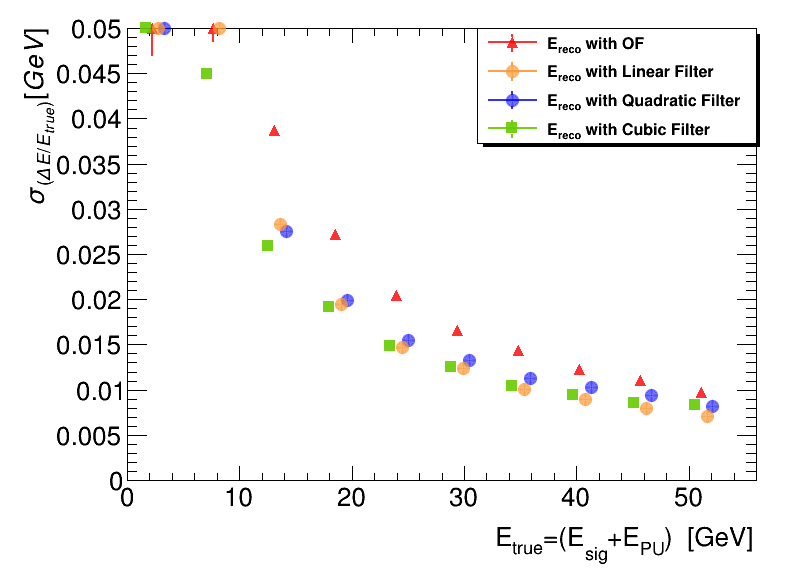

In [402]:
graph1, graph2, graph3, graph4, legend = rela_std_hist_gen(x, indices, scale_std_of, scale_std_lin, scale_std_quad, scale_std_cub, 0, 0.05)

canvas = ROOT.TCanvas("canvas", "Comparison Canvas", 800, 600)

graph1.Draw("APE")
graph2.Draw("SAMEPE")
graph3.Draw("SAMEPE")
graph4.Draw("SAMEPE")
legend.Draw()

canvas.Update()
canvas.Draw()
canvas.Print('rela_std_hec.pdf')

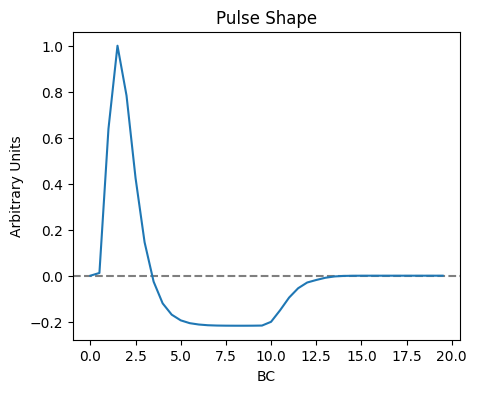

In [386]:
# Assuming you have pulse data available
n_points = len(pulse)
x = [i/2 for i in range(n_points)]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(5,4))

# Plot the pulse data
ax.axhline(0, color='k', alpha=0.5, linestyle='--') 
ax.plot(x, pulse, linestyle='-')

# Set x and y axis labels
ax.set_xlabel("BC")
ax.set_ylabel("Arbitrary Units")

# Set the title
ax.set_title("Pulse Shape")

# Save the plot to a file
plt.savefig("pulse_shape.pdf")

# Show the plot
plt.show()

### EMB data

In [114]:
names = ['onlyPileup', 'constGapLowE', 'rdGapLowE', 'constGapHighE',  'rdGapHighE']

In [441]:
i=3
name = names[i]

# load files
path = f'/Users/yy/docu/2023 summer/bv/1/OF5_EMB_EMMiddle_eta0.5125_phi0.0125_mu140_BT1_{name}_bunchLength5_size22/'
_, path1, path0 = os.listdir(path)

pulse, adc, signal, pileup, of_coeff, of_out = data_reader((path+path0), (path+path1))


In [442]:
ss=(signal+pileup)

to_cut=int(1e6)
ss = ss[to_cut: -to_cut]

of_pred, of_h = optimal(of_out, of_coeff, to_cut=to_cut)
lin_pred, lin_h = lin_les_fft(adc, signal, pileup)
quad_pred, quad_h = quad_les_fft(adc, signal, pileup)
cub_pred, cub_h = cub_les_fft(adc, signal, pileup)

In [405]:
print('========'+name+'========')

print('error for all BCID:  ')
print('optimal filter:  ', np.std(of_pred-ss))
print('linear FIR filter:  ', np.std(lin_pred-ss))
print('quadratic FIR filter:  ', np.std(quad_pred-ss))
print('cubic FIR filter:  ', np.std(cub_pred-ss))
print()

print('error for only 1 signal(ideal error):  ')
print('optimal filter:  ', error_bar(of_pred, adc[to_cut: -to_cut], of_h))
print('linear FIR filter:  ', error_bar(lin_pred, adc[to_cut: -to_cut], lin_h))
print('quadratic FIR filter:  ', error_bar(quad_pred, adc[to_cut: -to_cut], quad_h))
print('cubic FIR filter:  ', error_bar(cub_pred, adc[to_cut: -to_cut], cub_h))

========rdGapLowE========
error for all BCID:  
optimal filter:   1.841506583977256
linear FIR filter:   0.26887069847267175
quadratic FIR filter:   0.18396085437846785
cubic FIR filter:   0.1761076842629289

error for only 1 signal(ideal error):  
optimal filter:   0.08632504795158778
linear FIR filter:   (0.32909789198516215-0.01621365408745307j)
quadratic FIR filter:   (0.3309950198695565-0.31134042346944935j)
cubic FIR filter:   (0.5095373110960465+0.10445673504188338j)


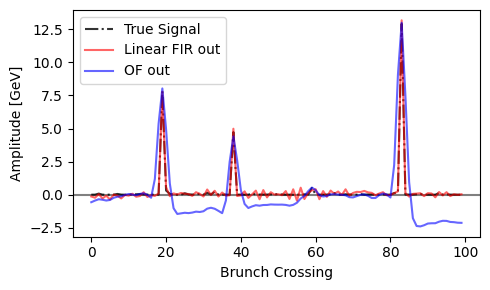

In [406]:

plt.figure(figsize=(5,3))

plt.axhline(0, color='gray', linestyle='-') 

plt.plot(ss[100200:100300], 'k-.', alpha=0.8, label='True Signal')
plt.plot(lin_pred[100200:100300], 'r', alpha=0.6, label='Linear FIR out')
plt.plot(of_pred[100200:100300], 'b', alpha=0.6, label='OF out')


plt.xlabel('Brunch Crossing')
plt.ylabel('Amplitude [GeV]')

plt.legend()
plt.tight_layout()
plt.savefig(name+'_emb_data.pdf')
plt.show()

In [407]:
indices, x = indices_gen(ss)


e_diff_of = (of_pred) - (ss)

mean_of, std_of, median_of, lower_98_of, higher_98_of, scale_mean_of, scale_std_of = arr_generator(e_diff_of, ss, indices)


e_diff_lin = (lin_pred) - (ss)

mean_lin, std_lin, median_lin, lower_98_lin, higher_98_lin, scale_mean_lin, scale_std_lin = arr_generator(e_diff_lin, ss, indices)


e_diff_quad = (quad_pred) - (ss)

mean_quad, std_quad, median_quad, lower_98_quad, higher_98_quad, scale_mean_quad, scale_std_quad = arr_generator(e_diff_quad, ss, indices)


e_diff_cub = (cub_pred) - (ss)

mean_cub, std_cub, median_cub, lower_98_cub, higher_98_cub, scale_mean_cub, scale_std_cub = arr_generator(e_diff_cub, ss, indices)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file rdGapLowEmean_emb.pdf has been created


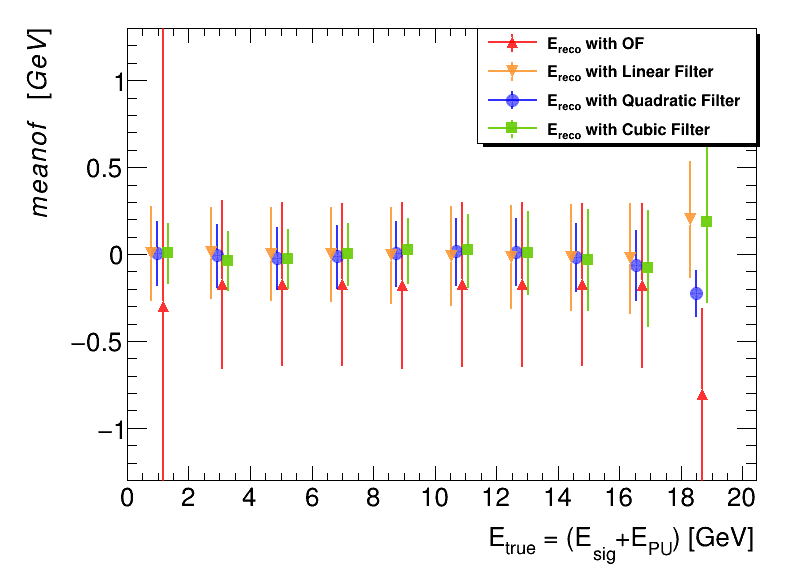

In [418]:
graph1, graph2, graph3, graph4, legend = mean_hist_gen(x, mean_of, std_of, mean_lin, std_lin, mean_quad, std_quad, mean_cub, std_cub, -1.3, 1.3)

canvas = ROOT.TCanvas("canvas", "Comparison Canvas", 800, 600)

graph1.Draw("APE")
graph2.Draw("SAMEPE")
graph3.Draw("SAMEPE")
graph4.Draw("SAMEPE")
legend.Draw()

canvas.Update()
canvas.Draw()
canvas.Print(name+'mean_emb.pdf')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file rdGapLowEstd_emb.pdf has been created


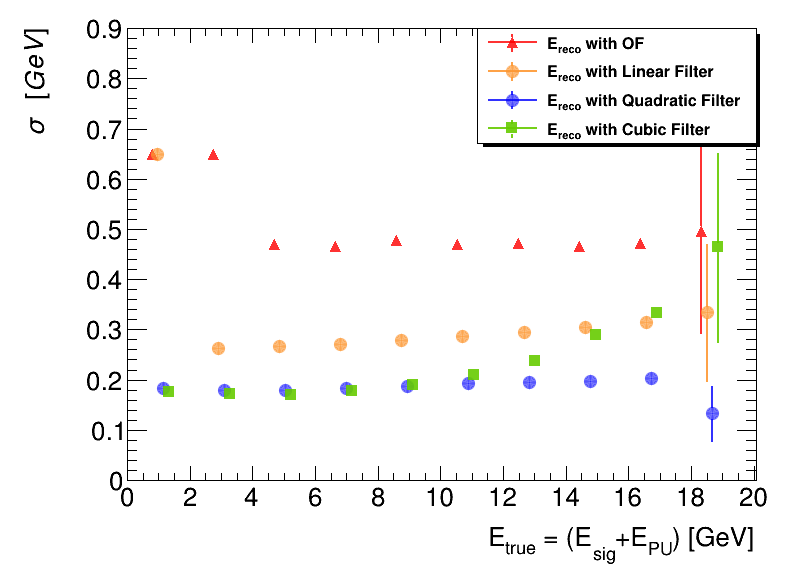

In [416]:
graph1, graph2, graph3, graph4, legend = std_hist_gen(x, indices, std_of, std_lin, std_quad, std_cub, 0, .9)

canvas = ROOT.TCanvas("canvas", "Comparison Canvas", 800, 600)

graph1.Draw("APE")
graph2.Draw("SAMEPE")
graph3.Draw("SAMEPE")
graph4.Draw("SAMEPE")
legend.Draw()

canvas.Update()
canvas.Draw()
canvas.Print(name+'std_emb.pdf')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file rdGapLowEmedian_emb.pdf has been created


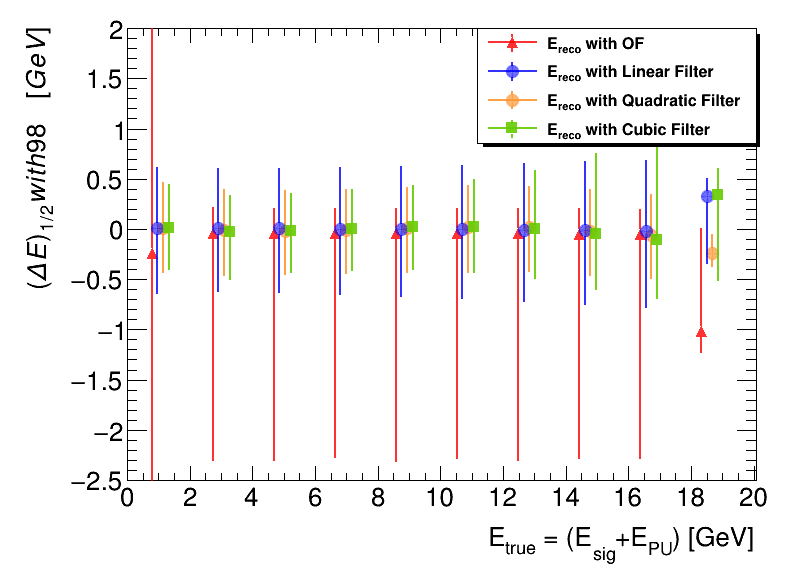

In [415]:
graph1, graph2, graph3, graph4, legend = median_hist_gen(x, median_of, lower_98_of, higher_98_of, median_quad, lower_98_quad, higher_98_quad, median_lin, lower_98_lin, higher_98_lin, median_cub, lower_98_cub, higher_98_cub, -2.5, 2)

canvas = ROOT.TCanvas("canvas", "Comparison Canvas", 800, 600)

graph1.Draw("APE")
graph2.Draw("SAMEPE")
graph3.Draw("SAMEPE")
graph4.Draw("SAMEPE")
legend.Draw()

canvas.Update()
canvas.Draw()
canvas.Print(name+'median_emb.pdf')


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file rdGapLowErela_std_emb.pdf has been created


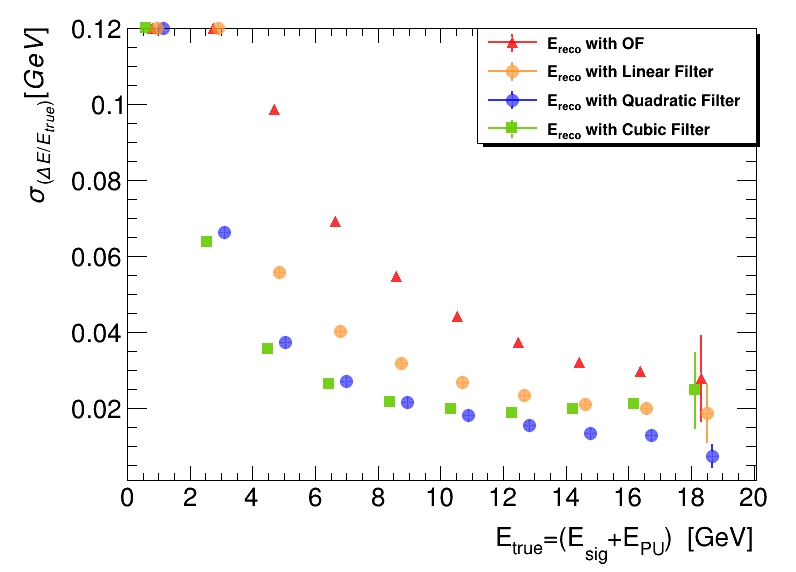

In [412]:
graph1, graph2, graph3, graph4, legend = rela_std_hist_gen(x, indices, scale_std_of, scale_std_lin, scale_std_quad, scale_std_cub, 0.001, 0.12)

canvas = ROOT.TCanvas("canvas", "Comparison Canvas", 800, 600)

graph1.Draw("APE")
graph2.Draw("SAMEPE")
graph3.Draw("SAMEPE")
graph4.Draw("SAMEPE")
legend.Draw()

canvas.Update()
canvas.Draw()
canvas.Print(name+'rela_std_emb.pdf')

In [443]:
filt = 'lin'
pred = lin_pred

bins = [0.2, 1, 130]
bin_indices = np.digitize(ss, bins)


i_arr = (np.where(bin_indices == 1)[0])

data = ((pred) - (ss))[i_arr]
mean_fir = data.mean()
std_fir = data.std()
lower, upper = np.percentile(data, [1, 99])
filtered_signal = data[(data >= lower) & (data <= upper)]
median_fir = np.median(filtered_signal)

e_diff_of = ((of_pred) - (ss))[i_arr]
mean_of = e_diff_of.mean()
std_of = e_diff_of.std()
lower, upper = np.percentile(e_diff_of, [1, 99])
filtered_signal = e_diff_of[(e_diff_of >= lower) & (e_diff_of <= upper)]
median_of = np.median(e_diff_of)

print('1-mean_fir/mean_of for ',filt,' fir filter is:   ',(1 - mean_fir/mean_of))
print('1-median_fir/median_of for ',filt,' fir filter is:   ',(1 - median_fir/median_of))
print('1-std_fir/std_of for ',filt,' fir filter is:   ',(1 - std_fir/std_of))

1-mean_fir/mean_of for  lin  fir filter is:    0.9227547225012924
1-median_fir/median_of for  lin  fir filter is:    -0.2648385637949784
1-std_fir/std_of for  lin  fir filter is:    0.9390469067216382


In [444]:
filt = 'quad'
pred = quad_pred

bins = [0.2, 1, 130]
bin_indices = np.digitize(ss, bins)


i_arr = (np.where(bin_indices == 1)[0])

data = ((pred) - (ss))[i_arr]
mean_fir = data.mean()
std_fir = data.std()
lower, upper = np.percentile(data, [1, 99])
filtered_signal = data[(data >= lower) & (data <= upper)]
median_fir = np.median(filtered_signal)

e_diff_of = ((of_pred) - (ss))[i_arr]
mean_of = e_diff_of.mean()
std_of = e_diff_of.std()
lower, upper = np.percentile(e_diff_of, [1, 99])
filtered_signal = e_diff_of[(e_diff_of >= lower) & (e_diff_of <= upper)]
median_of = np.median(e_diff_of)

print('1-mean_fir/mean_of for ',filt,' fir filter is:   ',(1 - mean_fir/mean_of))
print('1-median_fir/median_of for ',filt,' fir filter is:   ',(1 - median_fir/median_of))
print('1-std_fir/std_of for ',filt,' fir filter is:   ',(1 - std_fir/std_of))

1-mean_fir/mean_of for  quad  fir filter is:    0.9906048118855144
1-median_fir/median_of for  quad  fir filter is:    0.7663789932705518
1-std_fir/std_of for  quad  fir filter is:    0.968573420891927


In [445]:
filt = 'cub'
pred = cub_pred

bins = [0.2, 1, 130]
bin_indices = np.digitize(ss, bins)


i_arr = (np.where(bin_indices == 1)[0])

data = ((pred) - (ss))[i_arr]
mean_fir = data.mean()
std_fir = data.std()
lower, upper = np.percentile(data, [1, 99])
filtered_signal = data[(data >= lower) & (data <= upper)]
median_fir = np.median(filtered_signal)

e_diff_of = ((of_pred) - (ss))[i_arr]
mean_of = e_diff_of.mean()
std_of = e_diff_of.std()
lower, upper = np.percentile(e_diff_of, [1, 99])
filtered_signal = e_diff_of[(e_diff_of >= lower) & (e_diff_of <= upper)]
median_of = np.median(e_diff_of)

print('1-mean_fir/mean_of for ',filt,' fir filter is:   ',(1 - mean_fir/mean_of))
print('1-median_fir/median_of for ',filt,' fir filter is:   ',(1 - median_fir/median_of))
print('1-std_fir/std_of for ',filt,' fir filter is:   ',(1 - std_fir/std_of))

1-mean_fir/mean_of for  cub  fir filter is:    0.9863777719383958
1-median_fir/median_of for  cub  fir filter is:    0.8137829635663151
1-std_fir/std_of for  cub  fir filter is:    0.9749239334501203


In [446]:
name

'constGapHighE'

In [447]:
len(adc)

22000000